In [1]:
!pip install eTaPR-1.12-py3-none-any.whl

Processing ./eTaPR-1.12-py3-none-any.whl


In [2]:
!pip install tqdm==4.43.0

    100% |████████████████████████████████| 61kB 2.7MB/s ta 0:00:011
moviepy 0.2.3.2 has requirement tqdm==4.11.2, but you'll have tqdm 4.43.0 which is incompatible.
  Found existing installation: tqdm 4.11.2
    Uninstalling tqdm-4.11.2:
      Successfully uninstalled tqdm-4.11.2


In [2]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [3]:
TRAIN_DATASET = sorted([x for x in Path("data/training/").glob("*.csv")])
TRAIN_DATASET

[]

In [5]:
TEST_DATASET = sorted([x for x in Path("data/testing/").glob("*.csv")])
TEST_DATASET

[PosixPath('data/testing/test1.csv'),
 PosixPath('data/testing/test2.csv'),
 PosixPath('data/testing/test3.csv'),
 PosixPath('data/testing/test4.csv')]

In [6]:
VALIDATION_DATASET = sorted([x for x in Path("data/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('data/validation/validation.csv')]

In [7]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [8]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
5,2020-07-11 00:00:05,395.24640,12,10,52.79694,-1.8713,-1.88294,780.38776,28.02561,11512.0,...,829.60516,0.0,1.36810,8.86826,35.43700,12.01782,302.04718,296.83881,33.6555,6.0244
6,2020-07-11 00:00:06,395.34866,12,10,52.79694,-1.8651,-1.88294,783.65607,28.02301,11624.0,...,831.34473,0.0,1.35895,8.88958,35.43700,12.01782,301.52270,296.24207,33.6555,6.2372
7,2020-07-11 00:00:07,395.39975,12,10,52.79694,-1.7046,-1.88294,779.70721,28.02818,11736.0,...,821.34241,0.0,1.35971,8.91155,35.43700,12.01782,301.21527,295.68140,33.6555,6.4729
8,2020-07-11 00:00:08,395.34866,12,10,52.79694,-1.5038,-1.88294,779.65717,28.02385,11840.0,...,820.90759,0.0,1.35895,8.94309,35.43700,12.01782,300.72699,295.31976,33.6555,6.5049
9,2020-07-11 00:00:09,395.34866,12,10,52.79694,-1.3420,-1.87531,779.99420,28.02909,11936.0,...,821.77741,0.0,1.35895,8.93967,35.43700,12.01782,300.65466,294.88568,33.6555,6.3823


In [9]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

## Normalize

In [10]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [11]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [12]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,...,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378504,0.0,0.0,0.226596,0.353516,0.000161,0.399074,0.364415,0.794139,0.540538,...,0.592044,0.0,0.326835,0.254315,0.337223,0.916661,0.266791,0.251792,1.00000,0.512135
2,0.378463,0.0,0.0,0.226789,0.318663,0.000154,0.393283,0.451729,0.803903,0.538802,...,0.595523,0.0,0.326387,0.255304,0.337777,0.916661,0.265266,0.254707,1.00000,0.469622
3,0.378904,0.0,0.0,0.226808,0.238782,0.000154,0.393697,0.323289,0.813725,0.459532,...,0.596151,0.0,0.326343,0.257362,0.331746,0.916661,0.264379,0.253005,1.00000,0.446285
4,0.380282,0.0,0.0,0.226810,0.165794,0.000154,0.412796,0.654203,0.823039,0.333541,...,0.598763,0.0,0.326786,0.256312,0.337229,0.916661,0.262757,0.247706,1.00000,0.477489
5,0.379530,0.0,0.0,0.226810,0.124738,0.000154,0.398317,0.412616,0.832304,0.220924,...,0.600157,0.0,0.326830,0.257233,0.331692,0.916661,0.258607,0.248202,1.00000,0.535436
6,0.380345,0.0,0.0,0.226810,0.122953,0.000154,0.433968,0.319390,0.840522,0.141019,...,0.601429,0.0,0.321441,0.258057,0.331138,0.916661,0.256413,0.246260,1.00000,0.609982
7,0.380870,0.0,0.0,0.226810,0.182842,0.000154,0.392709,0.447405,0.848636,0.129432,...,0.595042,0.0,0.321350,0.258894,0.331083,0.916661,0.255150,0.244195,1.00000,0.693586
8,0.380479,0.0,0.0,0.226810,0.263980,0.000154,0.388015,0.345183,0.856218,0.215276,...,0.594120,0.0,0.320893,0.260061,0.331077,0.916661,0.253368,0.242782,1.00000,0.712285
9,0.380439,0.0,0.0,0.226810,0.332648,0.000223,0.391371,0.474158,0.863226,0.342822,...,0.594595,0.0,0.320847,0.260060,0.331077,0.916661,0.252944,0.241193,1.00000,0.674545


# Task 4: Create Training and Test Splits

In [13]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [14]:
boundary_check(TRAIN_DF)

(False, False, False)

In [15]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [16]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]

HBox(children=(FloatProgress(value=0.0, max=921514.0), HTML(value='')))


# of valid windows: 92134


{'ts': '2020-07-11 00:01:29',
 'given': tensor([[ 0.3790,  0.0000,  0.0000,  ...,  0.2650,  1.0000,  0.5673],
         [ 0.3785,  0.0000,  0.0000,  ...,  0.2518,  1.0000,  0.5121],
         [ 0.3785,  0.0000,  0.0000,  ...,  0.2547,  1.0000,  0.4696],
         ...,
         [ 0.3730,  0.0000,  0.0000,  ...,  0.4418,  1.0000,  0.5003],
         [ 0.3739,  0.0000,  0.0000,  ...,  0.4408,  1.0000,  0.5446],
         [ 0.3740,  0.0000,  0.0000,  ...,  0.4533,  1.0000,  0.5467]]),
 'answer': tensor([ 0.3740,  0.0000,  0.0000,  0.2268,  0.4452,  0.0002,  0.3055,
          0.6038,  0.4180,  0.5024,  0.5150,  0.4589,  0.1451,  0.0000,
          0.4793,  0.3571,  0.0011,  0.0000,  0.0000,  0.3899,  0.0000,
          0.0000,  0.0002,  0.9567,  0.0000,  0.4078,  0.3694,  0.0000,
          0.4136,  0.1396,  0.9837,  0.2692,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.4827,  0.7218,  0.0000,  1.0000,  0.1235,
          0.0000,  0.6566,  0.3800,  0.3533,  0.5260,  0.0000,  0.3044,
     

# Build Model

In [17]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [18]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(79, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=79, bias=True)
)

In [19]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
#             loss = loss_fn(answer, guess)
            loss = loss_fn(guess, answer)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [20]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32)

HBox(children=(FloatProgress(value=0.0, description='training', max=32.0, style=ProgressStyle(description_width='initial')), HTML(value='')))


CPU times: user 16min 3s, sys: 4min 41s, total: 20min 44s
Wall time: 19min 13s


In [21]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.08232898608548567, 32)

In [22]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

### Load the model

In [23]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

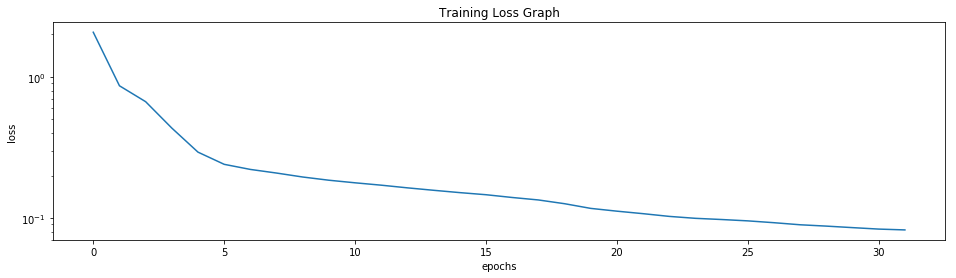

In [24]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

# Validation

In [25]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
5,2020-07-07 15:00:05,403.01621,12.0,10,51.94244,-1.3759,-1.86768,782.47815,28.03078,528,...,0.0,1.34293,10.74636,34.88770,12.26196,383.49969,388.00275,32.59527,6.1763,0
6,2020-07-07 15:00:06,403.06729,12.0,10,51.97296,-1.1795,-1.86768,785.01923,28.02993,504,...,0.0,1.34445,10.72779,34.90295,12.26196,383.13800,388.87079,32.59527,6.1388,0
7,2020-07-07 15:00:07,403.16956,12.0,10,51.97296,-1.0166,-1.86768,788.18091,28.02473,472,...,0.0,1.34979,10.64787,34.88770,12.26196,383.08374,386.61029,32.59527,5.8245,0
8,2020-07-07 15:00:08,403.16956,12.0,10,51.97296,-1.1606,-1.86768,786.43866,28.02899,448,...,0.0,1.35513,10.60738,34.88770,12.26196,383.31885,385.39856,32.59527,5.4822,0
9,2020-07-07 15:00:09,403.42511,12.0,10,51.97296,-1.4129,-1.86005,784.76270,28.03081,432,...,0.0,1.35513,10.52999,34.88770,12.26196,383.21039,385.88684,32.59527,5.4415,0


In [26]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [27]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [28]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

HBox(children=(FloatProgress(value=0.0, max=43112.0), HTML(value='')))


# of valid windows: 43112


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[ 0.4516,  0.0000,  0.0000,  ...,  0.5798,  0.5271,  0.4014],
         [ 0.4526,  0.0000,  0.0000,  ...,  0.5799,  0.5271,  0.3234],
         [ 0.4521,  0.0000,  0.0000,  ...,  0.5927,  0.5271,  0.3727],
         ...,
         [ 0.5267,  0.0000,  0.0000,  ...,  0.3193,  0.5271,  0.3745],
         [ 0.5257,  0.0000,  0.0000,  ...,  0.3134,  0.5271,  0.4363],
         [ 0.5252,  0.0000,  0.0000,  ...,  0.3089,  0.5271,  0.5319]]),
 'answer': tensor([ 0.5272,  0.0000,  0.0000,  0.1620,  0.2463,  0.0003,  0.4766,
          0.5115,  0.0012,  0.1518,  0.4905,  0.5506,  0.2870,  0.0000,
          0.4441,  0.4359,  0.0249,  0.0000,  0.0000,  0.3431,  0.0000,
          0.0000,  0.7577,  0.6856,  0.0000,  0.3794,  0.2522,  0.0000,
          0.3911,  0.0251,  0.9926,  0.3413,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.4110,  0.4692,  0.0000,  0.9992,  0.0003,
          0.0000,  0.5007,  0.3821,  0.2315,  0.6136,  0.0000

In [29]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [30]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

CPU times: user 5.11 s, sys: 924 ms, total: 6.04 s
Wall time: 5.48 s


In [31]:
CHECK_DIST.shape

(43112, 79)

In [32]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [33]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

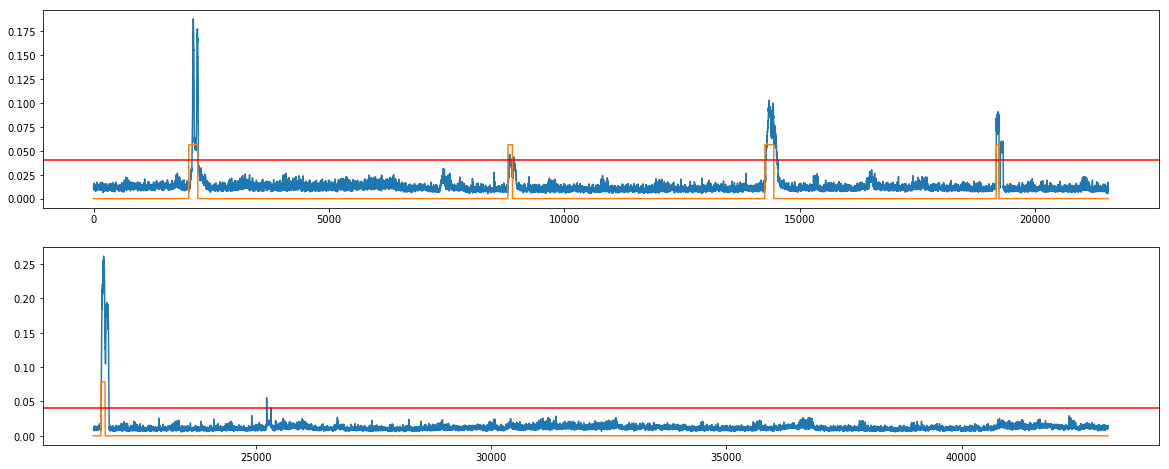

In [40]:
THRESHOLD = 0.04
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [41]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [42]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32), (43112,))

In [43]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [44]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [45]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 12.3 s, sys: 3.97 ms, total: 12.4 s
Wall time: 12.4 s


# Evaluation

In [46]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [47]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.907 (TaP: 0.933, TaR: 0.883)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


# Test

In [48]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
5,2020-07-09 15:00:05,384.25626,12.0,10,70.35980,-1.7018,-1.79901,772.96179,28.03166,136,...,936.58447,0.0,1.35590,13.92411,35.20813,12.02545,289.13489,281.97339,32.0,5.8864
6,2020-07-09 15:00:06,384.30737,12.0,10,70.35980,-1.6016,-1.79901,774.52435,28.02730,136,...,940.49835,0.0,1.35437,13.88320,35.20813,12.02545,289.06250,280.02026,32.0,5.7957
7,2020-07-09 15:00:07,384.61408,12.0,10,70.35980,-1.5087,-1.79901,777.53546,28.02824,136,...,939.19385,0.0,1.35437,13.89149,35.22338,12.02545,288.70081,280.25537,32.0,5.7640
8,2020-07-09 15:00:08,384.35852,12.0,10,70.35980,-1.4217,-1.79901,776.57739,28.02733,136,...,935.27991,0.0,1.35361,13.79502,35.20813,12.02545,289.82202,283.38397,32.0,5.7616
9,2020-07-09 15:00:09,384.35852,12.0,10,70.35980,-1.2343,-1.79901,777.11652,28.03081,136,...,941.80298,0.0,1.35666,13.85056,35.19287,12.02545,291.25073,290.76245,32.0,5.8855


### Normalize

In [49]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
5,0.273177,0.0,0.0,0.828325,0.189021,0.000999,0.309757,0.563602,0.010417,0.315313,...,0.678213,0.0,0.318749,0.450273,0.229730,0.944440,0.209821,0.193722,0.26162,0.495437
6,0.273661,0.0,0.0,0.828325,0.227996,0.000999,0.321457,0.448450,0.010417,0.398176,...,0.680321,0.0,0.317932,0.448807,0.229730,0.944440,0.209264,0.186689,0.26162,0.463343
7,0.276378,0.0,0.0,0.828325,0.266662,0.000999,0.356806,0.461905,0.010417,0.461918,...,0.679682,0.0,0.317851,0.448945,0.235808,0.944440,0.207982,0.186770,0.26162,0.449892
8,0.274427,0.0,0.0,0.828325,0.303088,0.000999,0.349466,0.439077,0.010417,0.511965,...,0.677069,0.0,0.317395,0.445647,0.230338,0.944440,0.211657,0.197217,0.26162,0.447771
9,0.274231,0.0,0.0,0.828325,0.376866,0.000999,0.354852,0.529238,0.010417,0.568110,...,0.681056,0.0,0.319147,0.447224,0.223710,0.944440,0.216871,0.222879,0.26162,0.487589


In [50]:
boundary_check(TEST_DF)

(True, True, False)

In [51]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]

HBox(children=(FloatProgress(value=0.0, max=358715.0), HTML(value='')))


# of valid windows: 358448


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[ 0.4516,  0.0000,  0.0000,  ...,  0.5798,  0.5271,  0.4014],
         [ 0.4526,  0.0000,  0.0000,  ...,  0.5799,  0.5271,  0.3234],
         [ 0.4521,  0.0000,  0.0000,  ...,  0.5927,  0.5271,  0.3727],
         ...,
         [ 0.5267,  0.0000,  0.0000,  ...,  0.3193,  0.5271,  0.3745],
         [ 0.5257,  0.0000,  0.0000,  ...,  0.3134,  0.5271,  0.4363],
         [ 0.5252,  0.0000,  0.0000,  ...,  0.3089,  0.5271,  0.5319]]),
 'answer': tensor([ 0.5272,  0.0000,  0.0000,  0.1620,  0.2463,  0.0003,  0.4766,
          0.5115,  0.0012,  0.1518,  0.4905,  0.5506,  0.2870,  0.0000,
          0.4441,  0.4359,  0.0249,  0.0000,  0.0000,  0.3431,  0.0000,
          0.0000,  0.7577,  0.6856,  0.0000,  0.3794,  0.2522,  0.0000,
          0.3911,  0.0251,  0.9926,  0.3413,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.4110,  0.4692,  0.0000,  0.9992,  0.0003,
          0.0000,  0.5007,  0.3821,  0.2315,  0.6136,  0.0000

In [52]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 40.8 s, sys: 7.88 s, total: 48.7 s
Wall time: 44.1 s


In [53]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

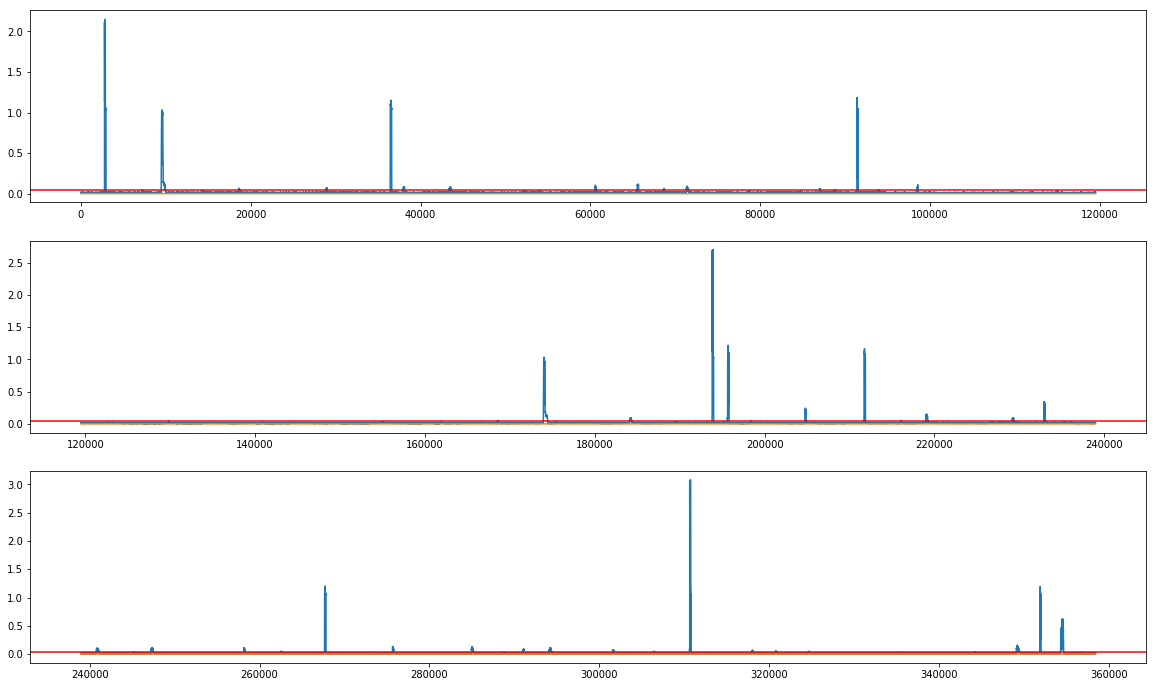

In [54]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [55]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32), (358448,))

In [56]:
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
2020-07-09 15:00:05,2020-07-09 15:00:05,0.0
2020-07-09 15:00:06,2020-07-09 15:00:06,0.0
2020-07-09 15:00:07,2020-07-09 15:00:07,0.0
2020-07-09 15:00:08,2020-07-09 15:00:08,0.0


In [57]:
submission.to_csv('baseline.csv', index=False)